In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import glob
import tables
import matplotlib.axes as ax
import astropy.units as u
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from pathlib import Path
from astropy.table import Table, vstack
%matplotlib inline

In [2]:
# Choose here whether we're dealing with DL1 or DL2 files. The choice of files has to be consistent
# with the table name set below!
#tablename = '/dl1/event/telescope/parameters/LST_LSTCam'
tablename = "/dl2/event/telescope/parameters/LST_LSTCam"

# Define datasets (DL1 OR DL2):  dataset1: Monte Carlo;  dataset2: real data

#dataset1 = "/nfs/cta-ifae/moralejo/CTA/LST/MC/20201017_v0.6.3_prod5_LST1/DL1/proton_LST1_20deg_DL1_merged.h5"
dataset1 = "/nfs/cta-ifae/moralejo/CTA/LST/MC/20201017_v0.6.3_prod5_LST1/DL2/dl2_proton_zenith_20deg_south_pointing_20201017_v0.6.3_prod5_LST1_local_DL1_testing.h5"
#dataset1 = "/nfs/cta-ifae/moralejo/CTA/LST/MC/20201017_v0.6.3_prod5_LST1/DL2/Ruben/dl2_proton_zenith_20deg_south_pointing_20201017_v0.6.3_prod5_LST1_local_DL1_testing.h5"


# NOTE: if the directory containing dataset2 also has the muons*fits files, telescope efficiency plot 
# distribution will be shown
# The light scale factor will be applied to the inensity parameter of real data. Note that the factor 
# from muon ring analysis is not enough, because with lower light also some pixels will be lost at the 
# cleaning level, so intensity does not scale like individual pixel charge. 

#dataset2 = "/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL1/20200117/v0.6.1_v05/dl1_LST-1.Run01815.000*.h5"
#light_scale_factor = 0.985

#light_scale_factor = 1.
#dataset2 = "/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL2/20200127/v0.6.1_v05/Ruben/dl2_Run01881_merged.h5"


#dataset2 = "/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL1/20200127/v0.6.1_v05/dl1_LST-1.Run01881.000*.h5"
light_scale_factor = 1.
#SAME DATA as DL2 level:
dataset2 = "/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL2/20200127/v0.6.1_v05/dl2_LST-1.Run01881.000*.h5"

#dataset2 = "/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL1/20200710/v0.6.1_v05/dl1_LST-1.Run02182.000*.h5"
#light_scale_factor = 1.235

#dataset2 = "/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL1/20200716/v0.6.1_v05/dl1_LST-1.Run02249.000*.h5"
#light_scale_factor = 1.21

#dataset2 = "/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL1/20200815/v0.6.1_v05/dl1_LST-1.Run02449.000*.h5"
#light_scale_factor = 1.095

#dataset2 = "/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL1/20200920/v0.6.1_v05/dl1_LST-1.Run02771.000*.h5"
#light_scale_factor = 1.215
# SAME DATA as DL2 level, for tests:
#dataset2 = "/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL2/20200920/v0.6.1_v05/dl2_LST-1.Run02771.000*.h5"


# Read in MC generation parameters:
mcfile = tables.open_file(dataset1)
mcconfig = mcfile.root.simulation.run_config
simu_index = mcconfig.col('spectral_index')[0]
# Number of produced MC events, including shower re-uses:
num_mc_events = (mcconfig.col('num_showers')*mcconfig.col('shower_reuse')).sum()
print(num_mc_events)
# We assume that all MC runs inside the file have the same generation parameters:
cone_radius = mcconfig.col('max_viewcone_radius')[0]*u.deg
generation_circle_radius = mcconfig.col('max_scatter_range')[0] # m
energy_min = mcconfig.col('energy_range_min')[0] # TeV
energy_max = mcconfig.col('energy_range_max')[0]  # TeV
mcfile.close()

energy_norm = 1. # TeV Just a reference energy we will use to weight the MC


# bess_index = -2.7
#def dfde(energy): # energy in TeV BESS proton spectrum, corrected for heavier nuclei
#    factor_for_heavier_nuclei = 1.5
#    return factor_for_heavier_nuclei*9.6e-2*np.power(energy/energy_norm,bess_index) # (m^2 s sr TeV)^-1 

# Better use DAMPE, from https://inspirehep.net/files/62efc8374ffced58ea7e3a333bfa1217
# p+He spectrum, energy in TeV:

def dfde(energy):
    dfde.E_GeV = np.array([5., 50.5185, 78.9163, 124.383, 199.575, 317.380, 495.808, 788.531, 1254.06, 1994.62, 3116.73, 4957.69, 7956.55, 12321.0, 19946.8, 100269])
# E^2.7 J(E), GeV^1.7 m^-2 sr^-1 s^1,  E in GeV, 
    dfde.E27J = np.array([18616.8, 18616.8, 18461.3, 18381.3, 18301.1, 18296.6, 18443.5, 18968.4, 19417.6, 20547.3, 22509.0, 24319.2, 25978.2, 27183.8, 27254.7, 27390.4])
    dfde.dampf = interp1d(np.log10(dfde.E_GeV), dfde.E27J)
# returns log10(dF/dE) in (m^2 s sr TeV)^-1
    return 1.e3*np.power(energy*1.e3, -2.7)*dfde.dampf(np.log10(energy*1.e3))

rate_cr, err = quad(dfde, energy_min, energy_max)  # 1 / (m2 s sr)
rate_cr *= 2*np.pi*(1.-np.cos(cone_radius))*np.pi*np.square(generation_circle_radius)

print('Rate of CRs in MC generation ranges:', rate_cr)

# energy in TeV. Just the shape, =1 at energy_norm by construction:
def original_mc_spec(energy): 
    return np.power(energy/energy_norm,simu_index)
# energy in TeV. Just the shape, =1 at energy_norm by construction:
def modified_mc_spec(energy): # energy in TeV
    return dfde(energy)/dfde(energy_norm)

integral_a, err_a = quad(original_mc_spec, energy_min, energy_max)
integral_b, err_b = quad(modified_mc_spec, energy_min, energy_max)
# print(integral_a, integral_b, integral_b/integral_a)


Spectral_normalization_factor = rate_cr / (num_mc_events*integral_b/integral_a)

print('Spectral normalization factor:', Spectral_normalization_factor)



2500000000
Rate of CRs in MC generation ranges: 147368623.76376614
Spectral normalization factor: 0.004115440608504619


In [3]:
table1 = pd.core.frame.DataFrame()
table2 = pd.core.frame.DataFrame()

for file in sorted(glob.glob(dataset1)):
    print(file)
    table1 = table1.append(pd.read_hdf(file, tablename))
    print(len(table1), 'rows')
    
for file in sorted(glob.glob(dataset2)):
    print(file)
    table2 = table2.append(pd.read_hdf(file, tablename))

/nfs/cta-ifae/moralejo/CTA/LST/MC/20201017_v0.6.3_prod5_LST1/DL2/dl2_proton_zenith_20deg_south_pointing_20201017_v0.6.3_prod5_LST1_local_DL1_testing.h5
647223 rows
/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL2/20200127/v0.6.1_v05/dl2_LST-1.Run01881.0000.h5
/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL2/20200127/v0.6.1_v05/dl2_LST-1.Run01881.0001.h5
/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL2/20200127/v0.6.1_v05/dl2_LST-1.Run01881.0002.h5
/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL2/20200127/v0.6.1_v05/dl2_LST-1.Run01881.0003.h5
/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL2/20200127/v0.6.1_v05/dl2_LST-1.Run01881.0004.h5


In [4]:
print(table1.columns)
print(table2.columns)

Index(['intensity', 'log_intensity', 'x', 'y', 'r', 'phi', 'length', 'width',
       'psi', 'skewness', 'kurtosis', 'time_gradient', 'intercept',
       'leakage_intensity_width_1', 'leakage_intensity_width_2',
       'leakage_pixels_width_1', 'leakage_pixels_width_2', 'n_pixels',
       'concentration_cog', 'concentration_core', 'concentration_pixel',
       'n_islands', 'obs_id', 'event_id', 'calibration_id', 'mc_energy',
       'log_mc_energy', 'mc_alt', 'mc_az', 'mc_core_x', 'mc_core_y',
       'mc_h_first_int', 'mc_type', 'mc_az_tel', 'mc_alt_tel', 'mc_x_max',
       'mc_core_distance', 'wl', 'tel_id', 'tel_pos_x', 'tel_pos_y',
       'tel_pos_z', 'trigger_type', 'disp_dx', 'disp_dy', 'disp_norm',
       'disp_angle', 'disp_sign', 'src_x', 'src_y', 'log_reco_energy',
       'reco_energy', 'reco_disp_dx', 'reco_disp_dy', 'reco_src_x',
       'reco_src_y', 'reco_alt', 'reco_az', 'reco_type', 'gammaness'],
      dtype='object')
Index(['intensity', 'log_intensity', 'x', 'y', 'r', 'phi

In [5]:
refmuonpandas = None
# Reference set of muon files, for comparison:
refmuonfiles = glob.glob('/nfs/cta-ifae/moralejo/CTA/LST/RealData/DL1/20200127/v0.6.1_v05/muons*.fits')
if len(refmuonfiles) > 0:
    refmuonfiles.sort()
    refmuontable = Table.read(refmuonfiles[0])
    for file in refmuonfiles[1:]:
        mm = Table.read(file)
        refmuontable = vstack([refmuontable, mm])
    refmuonpandas = refmuontable.to_pandas()

path = Path(dataset2)
muonpandas = None
muonfiles = glob.glob(str(Path(path.parent,'muons*.fits')))
if len(muonfiles) > 0:
    muonfiles.sort()
    muontable = Table.read(muonfiles[0])
    for file in muonfiles[1:]:
        mm = Table.read(file)
        muontable = vstack([muontable, mm])
    muonpandas = muontable.to_pandas()
    print(muonpandas.columns)

In [6]:
if muonpandas is not None:
    muonmask = (muonpandas['ring_containment']>0.99) & (muonpandas['size_outside']<1.)
    plt.hist(muonpandas[muonmask]['muon_efficiency']*light_scale_factor, bins=200, range=(0.,0.5),
             density=True)

    if refmuonpandas is not None:
        refmuonmask = (refmuonpandas['ring_containment']>0.99) & (refmuonpandas['size_outside']<1.)
        plt.hist(refmuonpandas[refmuonmask]['muon_efficiency'], bins=200, range=(0.,0.5), 
                 histtype='step', density=True)
    plt.show()

Index(['intensity', 'log_intensity', 'x', 'y', 'r', 'phi', 'length', 'width',
       'psi', 'skewness', 'kurtosis', 'time_gradient', 'intercept',
       'leakage_intensity_width_1', 'leakage_intensity_width_2',
       'leakage_pixels_width_1', 'leakage_pixels_width_2', 'n_pixels',
       'concentration_cog', 'concentration_core', 'concentration_pixel',
       'n_islands', 'alt_tel', 'az_tel', 'obs_id', 'event_id',
       'calibration_id', 'dragon_time', 'ucts_time', 'tib_time', 'mc_type',
       'mc_core_distance', 'wl', 'tel_id', 'tel_pos_x', 'tel_pos_y',
       'tel_pos_z', 'trigger_type', 'ucts_trigger_type', 'trigger_time',
       'log_reco_energy', 'reco_energy', 'reco_disp_dx', 'reco_disp_dy',
       'reco_src_x', 'reco_src_y', 'reco_alt', 'reco_az', 'reco_type',
       'gammaness'],
      dtype='object')


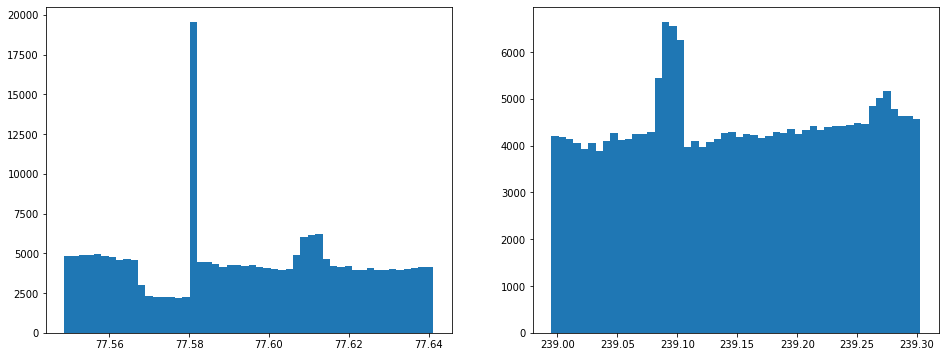

In [7]:
print(table2.columns)
fig = plt.figure(figsize=(16,6))
fig.add_subplot(1, 2, 1)
plt.hist(np.rad2deg(table2['alt_tel']), bins=50)
fig.add_subplot(1, 2, 2)
plt.hist(np.rad2deg(table2['az_tel']), bins=50)
plt.show()

In [8]:
#print(table1[table1['intensity']>0]['intensity'])
#print(table1['intensity'])

In [9]:
mc_energy = np.array(table1['mc_energy'])
w1 = Spectral_normalization_factor.value*modified_mc_spec(mc_energy)/original_mc_spec(mc_energy)


1347 flatfield events in dataset 2


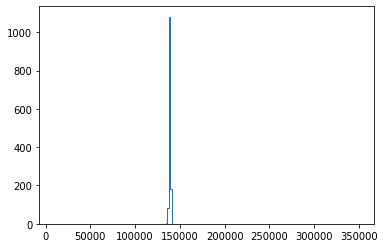

In [10]:
maskff = (table2['intensity']>1e5) & (table2['width']>1)
ff2 = table2[maskff]['intensity']
nff2=len(ff2)
print(nff2, 'flatfield events in dataset 2')
plt.hist(ff2,bins=200,histtype='step', range=(1.e4,3.5e5))

plt.show()

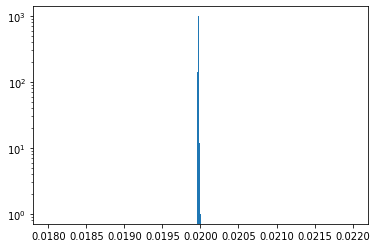

0.01997145 s between flatfield events
Aprox. total time dataset 2: 26.90 s


In [11]:
tai2 = table2[(table2['intensity']>1e5)&(table2['width']>1)]['dragon_time']
t2 = (tai2 - np.tile(np.array(tai2)[0], len(tai2)))

tdiff = np.subtract(np.array(t2[1:]), np.array(t2[0:len(t2)-1]))

htdiff = plt.hist(tdiff, bins=500, range=(0.018,0.022), log=True)
plt.show()
mean_delta_t = np.mean(tdiff[tdiff<0.022])
print("%.8f" % mean_delta_t, 's between flatfield events')
# We assume we have the same rate of flatfield events (could check it, but anyway)

aprox_time = nff2*mean_delta_t
print('Aprox. total time dataset 2:', "%.2f" % aprox_time, 's')


sum of event-to-event time gaps: 28.97132635116577 s
Live time: 27.29640385116577 s
[ 7811.88560863 -8219.29439979]


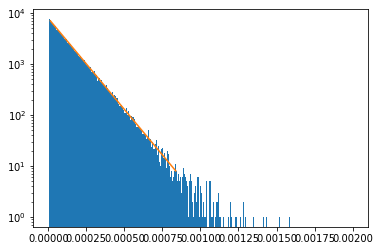

In [12]:
times = table2['dragon_time']
tdiff = np.subtract(np.array(times[1:]), np.array(times[:-1]))
htdiff, bins, _ = plt.hist(tdiff, bins=500, range=(0.,0.002), log=True)
elapsedt = tdiff[tdiff<0.005].sum()
# excluding large gaps (stops of observation)
print('sum of event-to-event time gaps:', elapsedt, 's')
def exponential(x, a, b):
    return a*np.exp(b*x)

# dead time per event (seconds, aprox, check!):
deadt = 7.5e-6 
total_deadt = len(times)*deadt
livetime = elapsedt - total_deadt
print('Live time:', livetime, 's')

x = 0.5*(bins[:-1]+bins[1:])
mask = (htdiff>10) & (x>1.e-5)

best_vals, covar = curve_fit(exponential, x[mask], htdiff[mask], 
                             sigma=np.sqrt(htdiff[mask]), absolute_sigma=True,
                             p0=[1.e4,-2.e4], method='lm')
print(best_vals)
plt.plot(x[mask], exponential(x[mask], best_vals[0], best_vals[1]), '-')

plt.show()

w2 = np.tile([1./livetime], len(table2))

In [13]:
#print(table1) # just to show all columns and a few rows

max_radius = 1.5
#max_radius = 0.5
x_center = 0.0
y_center = 0.0

#max_radius = 0.45
#x_center = -0.1
#y_center = -0.4

#max_radius = 0.45
#x_center = -0.2
#y_center =  0.2


radius_mask1 = np.hypot(table1['x']-x_center,table1['y']-y_center)<max_radius
mask1 = radius_mask1 & (table1['intensity']>0)

intensity1 = table1[mask1]['intensity']
#intensity1 = table1[mask1]['concentration_pixel']*table1[mask1]['intensity']
logintensity1 = np.log10(intensity1)

radius_mask2 = (np.hypot(table2['x']-x_center,table2['y']-y_center)<max_radius)
ped_mask2 = np.logical_not(table2['trigger_type']==32)
mask2 = radius_mask2 & ped_mask2 & (table2['intensity']>0) & ~maskff

intensity2 = light_scale_factor*table2[mask2]['intensity'] # Correction for possible miscalibration!!
#intensity2 = light_scale_factor*table2[mask2]['concentration_pixel']*table2[mask2]['intensity']
logintensity2 = np.log10(intensity2)


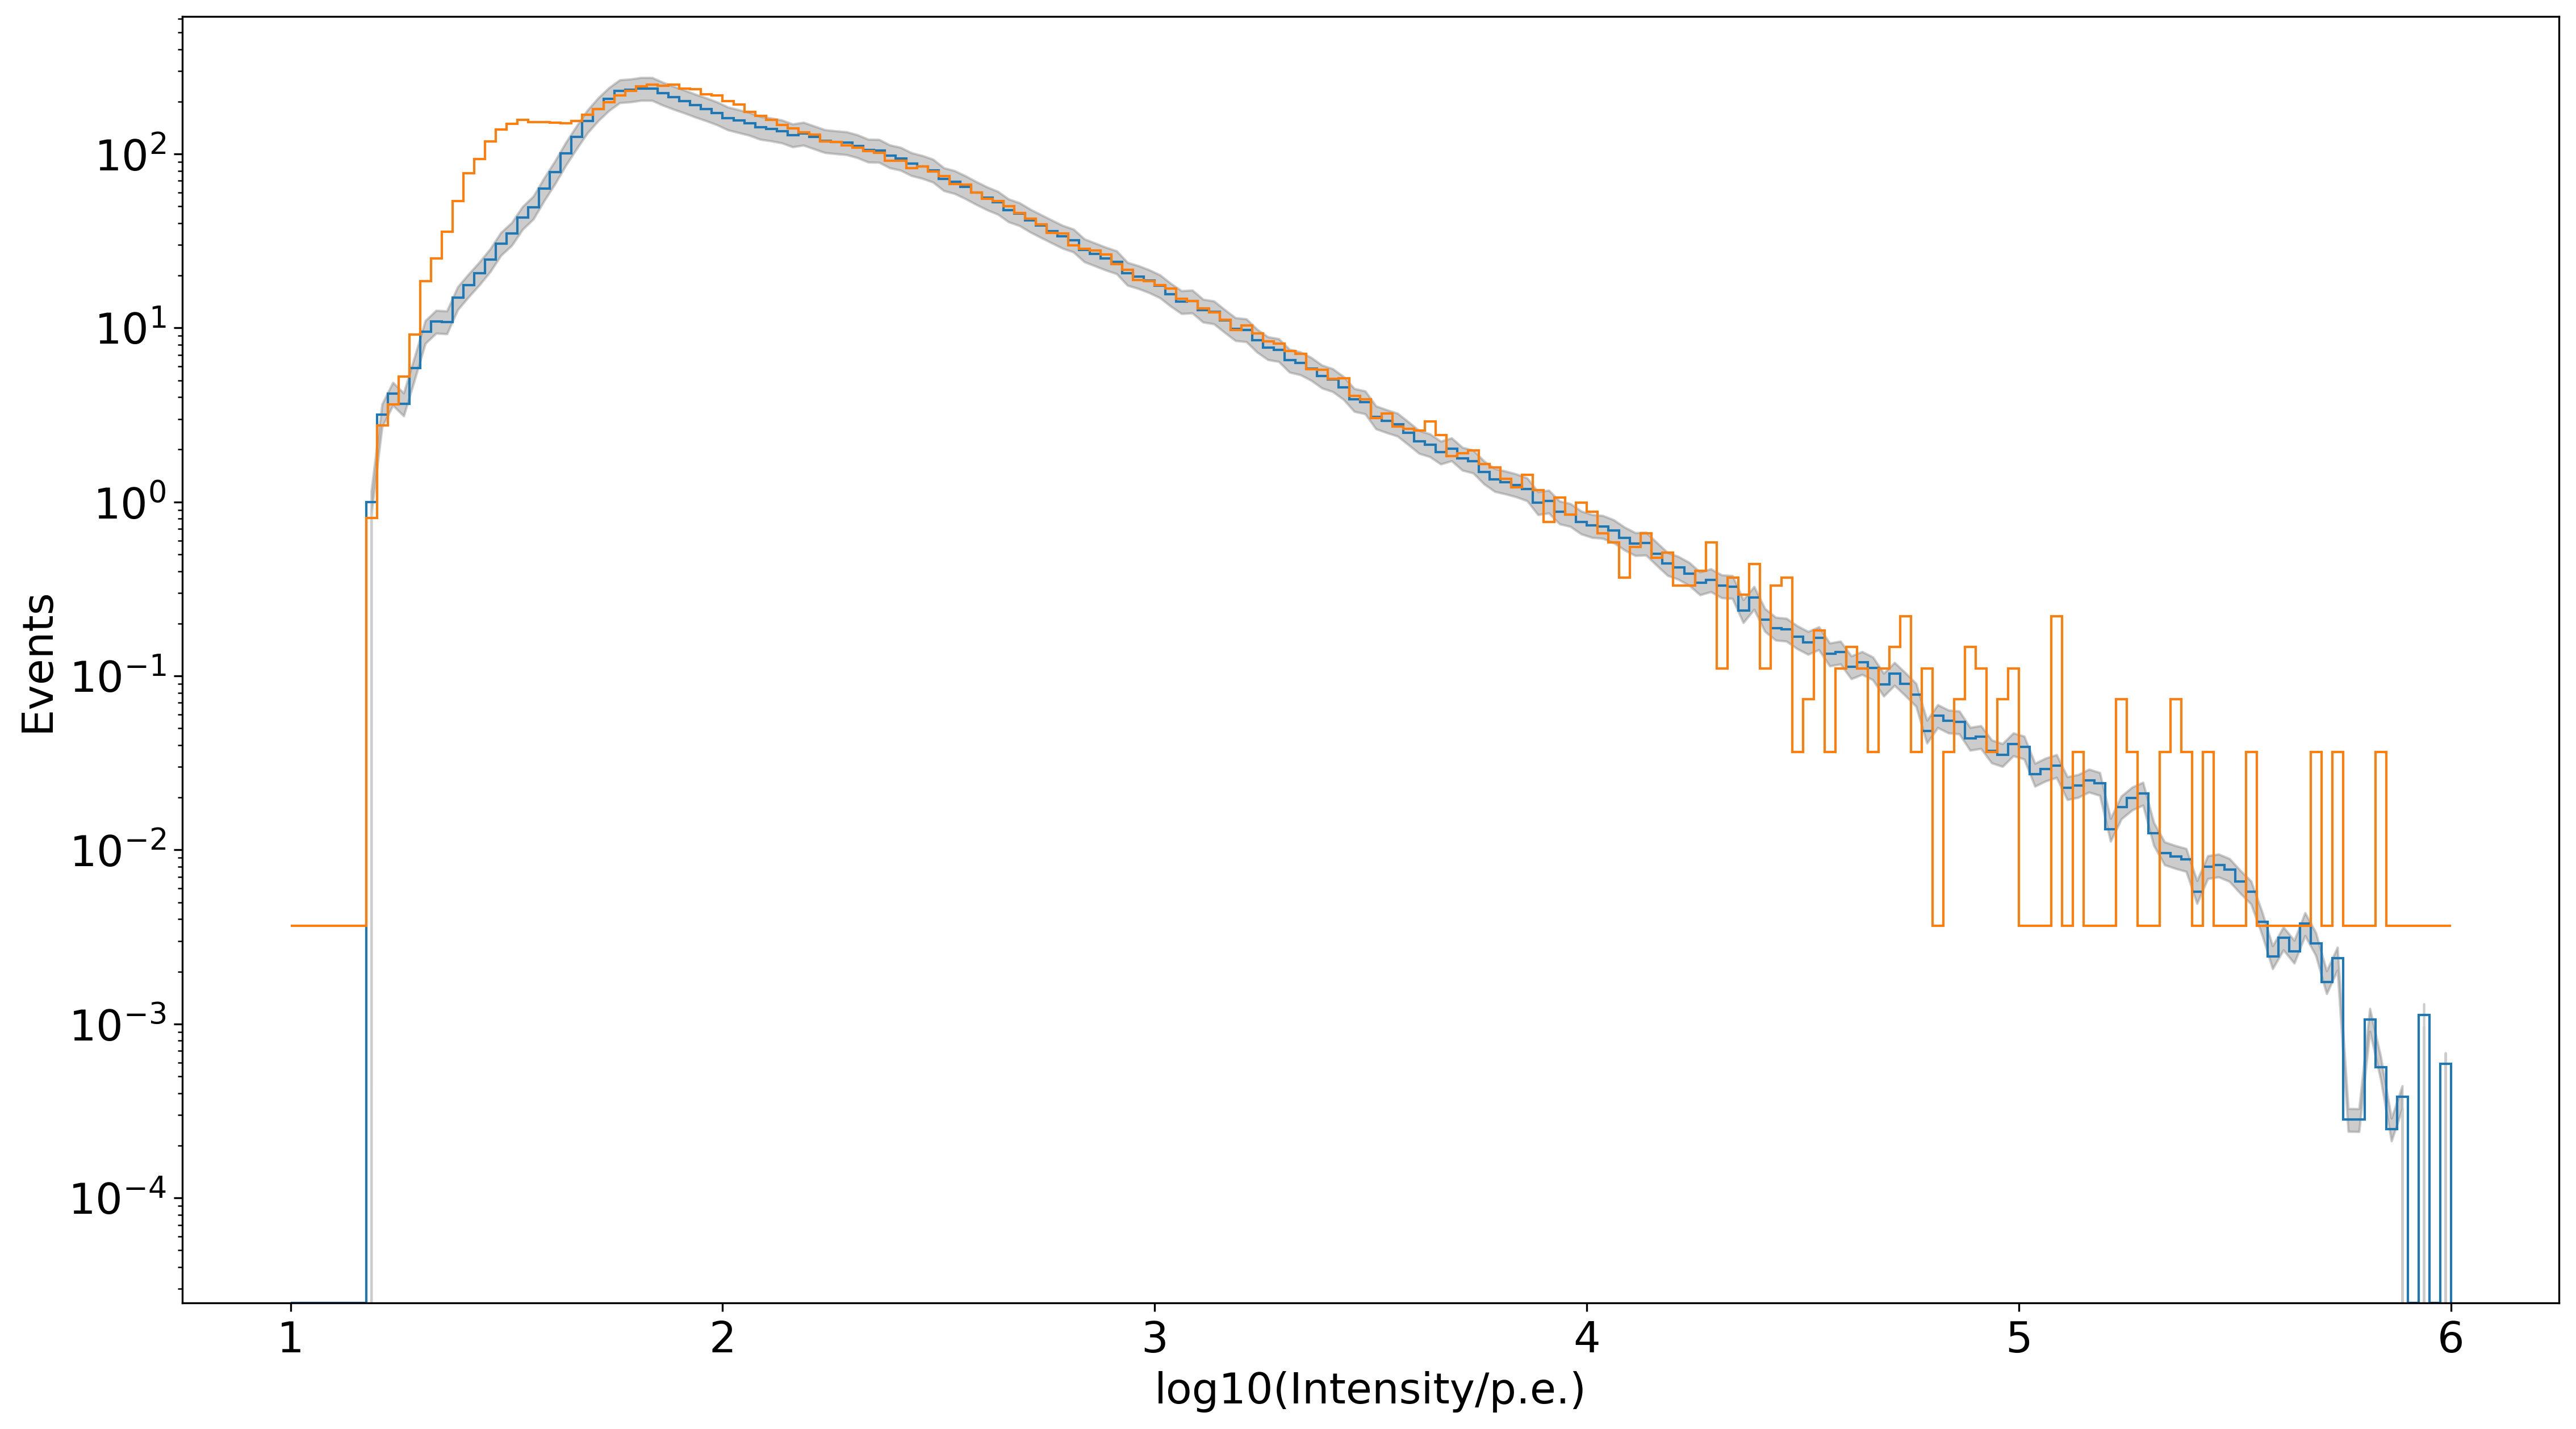

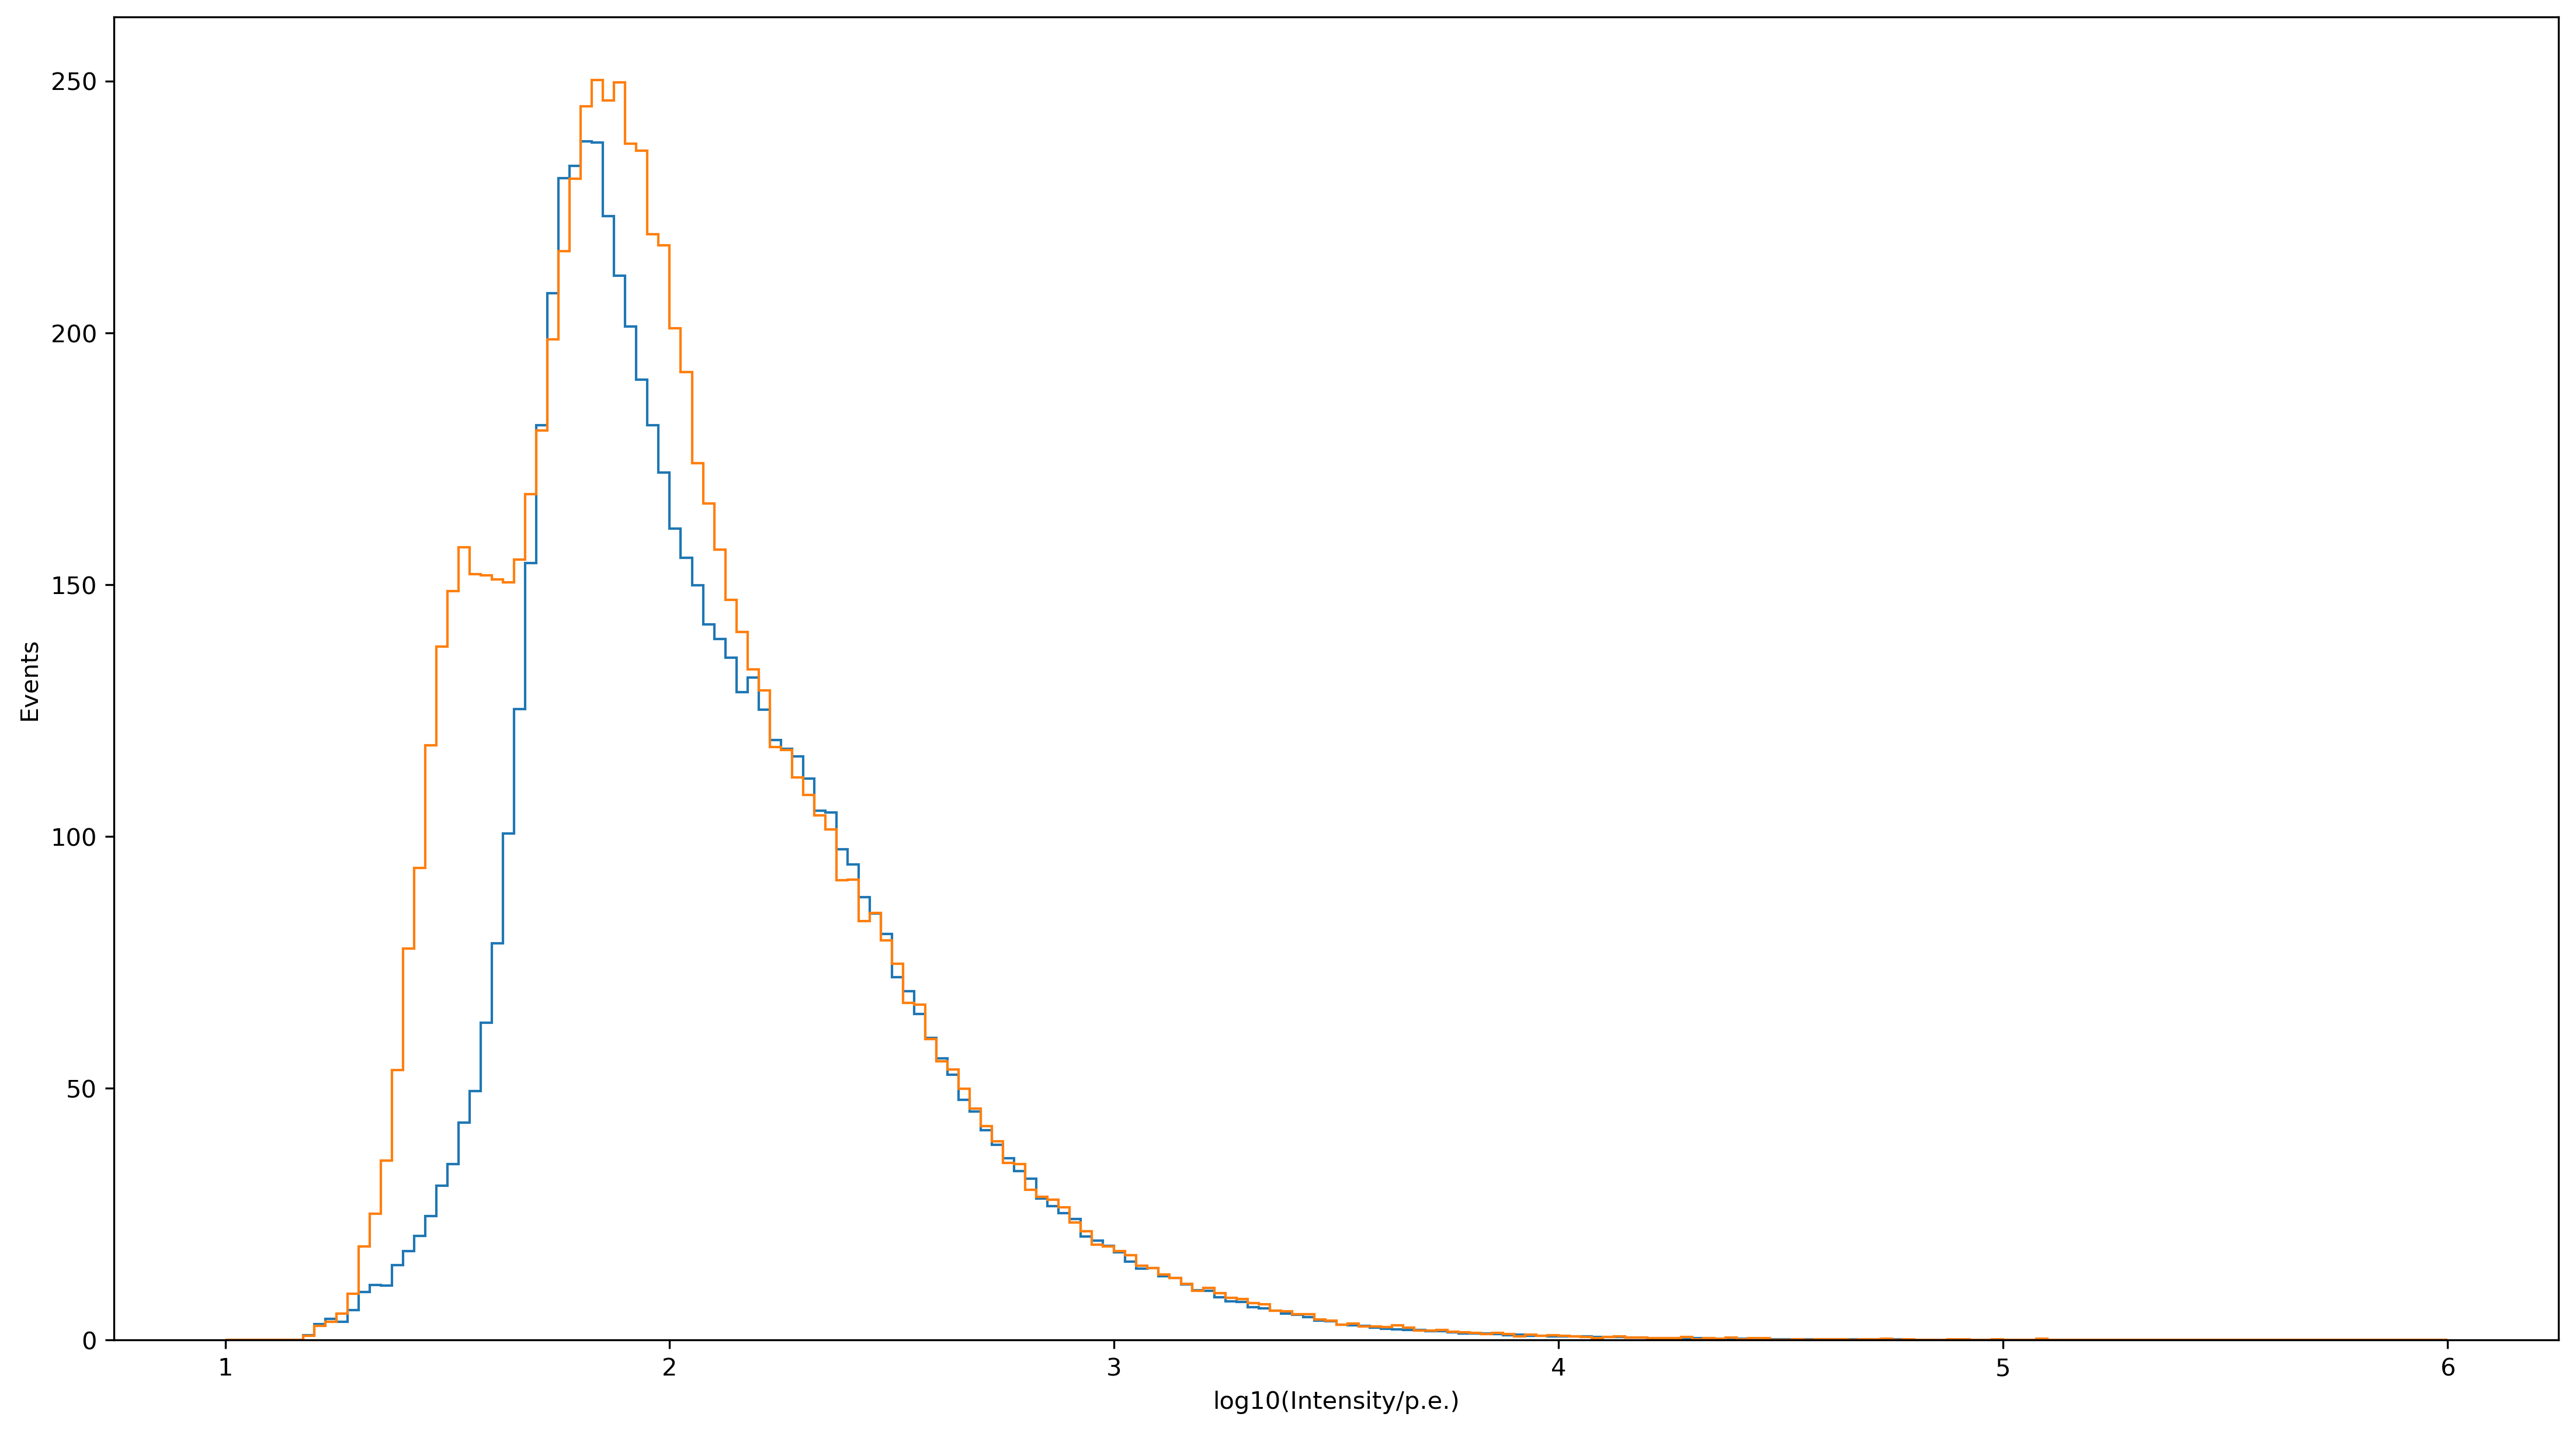

MC rate of images: 6742.628372584507 events/s
Real data, rate of images: 8082.7 events/s


In [14]:
fig=plt.figure(figsize=(18, 10), dpi= 300)
numbins = 200

# Aprox systematics (e.g. DAMPE: 12% to 16%) in flux
RelativeFluxSystematics = 0.15

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


h1 = plt.hist(logintensity1, bins=numbins, histtype='step', weights=w1[mask1], log=True, range=(1.,6.))

plt.fill_between(0.5*(h1[1][1:]+h1[1][:-1]), 
                 h1[0]*(1.+RelativeFluxSystematics), 
                 h1[0]*(1.-RelativeFluxSystematics), color="grey", alpha=0.4)

h2 = plt.hist(logintensity2, bins=numbins, histtype='step', weights=w2[mask2], log=True, range=(1.,6.))
plt.xlabel("log10(Intensity/p.e.)", fontsize=18)
plt.ylabel("Events", fontsize=18)
plt.show()

fig2=plt.figure(figsize=(18, 10), dpi= 300)
h1lin = plt.hist(logintensity1, bins=numbins, histtype='step', log=False, weights=w1[mask1], range=(1.,6.))
h2lin = plt.hist(logintensity2, bins=numbins, histtype='step', log=False, weights=w2[mask2], range=(1.,6.))

plt.xlabel("log10(Intensity/p.e.)")
plt.ylabel("Events")
plt.show()

print('MC rate of images:',np.sum(h1lin[0]),'events/s')
print('Real data, rate of images:', "%.1f" % ((len(logintensity2)-nff2)/livetime), 'events/s')

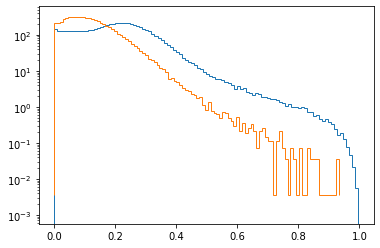

In [15]:
# Plot the distribution of another parameter, for a given intensity cut:
paramname = 'gammaness'
intensity_cut=50

t1 = table1[mask1][intensity1>intensity_cut]
t2 = table2[mask2][intensity2>intensity_cut]
ww1 = w1[mask1][intensity1>intensity_cut]
ww2 = w2[mask2][intensity2>intensity_cut]

numbins=100
param1 = t1[paramname]
param2 = t2[paramname]

plt.hist(param1, bins=numbins, histtype='step', weights=ww1, log=True)
plt.hist(param2, bins=numbins, histtype='step', weights=ww2, log=True)
plt.show()

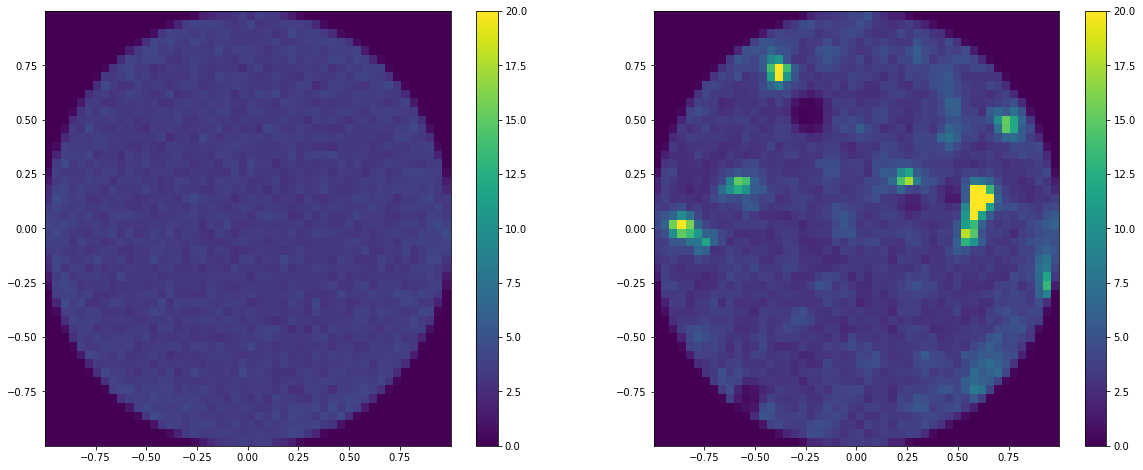

In [16]:
min_intensity = 0.
maxz = 20.

mask1a = np.logical_not((table1['intensity']>1e5)&(table1['width']>1))
mask1b = ~np.isnan(table1['intensity'])
mask1c = table1['intensity']>min_intensity
mask1 = mask1a&mask1b&mask1c


fig = plt.figure(figsize=(20,8))
fig.add_subplot(1, 2, 1)
h1 = plt.hist2d(-table1[mask1]['y'], -table1[mask1]['x'], weights=w1[mask1],
                bins=50, vmax=maxz) #, norm=colors.LogNorm())
plt.colorbar(h1[3])
plt.gcf().gca().add_artist(plt.Circle((x_center, y_center), max_radius, fill=False))

mask2a = np.logical_not((table2['intensity']>1e5)&(table2['width']>1))
mask2b = ~np.isnan(table2['intensity'])
mask2c = table2['intensity']>min_intensity
mask2d = np.logical_not(table2['trigger_type']==32)
mask2 = mask2a&mask2b&mask2c&mask2d&~maskff


fig.add_subplot(1, 2, 2)
h2 = plt.hist2d(-table2[mask2]['y'], -table2[mask2]['x'], weights=w2[mask2],
                bins=50, vmax=maxz) #, norm=colors.LogNorm())
plt.colorbar(h2[3])
plt.gcf().gca().add_artist(plt.Circle((x_center, y_center), max_radius, fill=False))


plt.show()

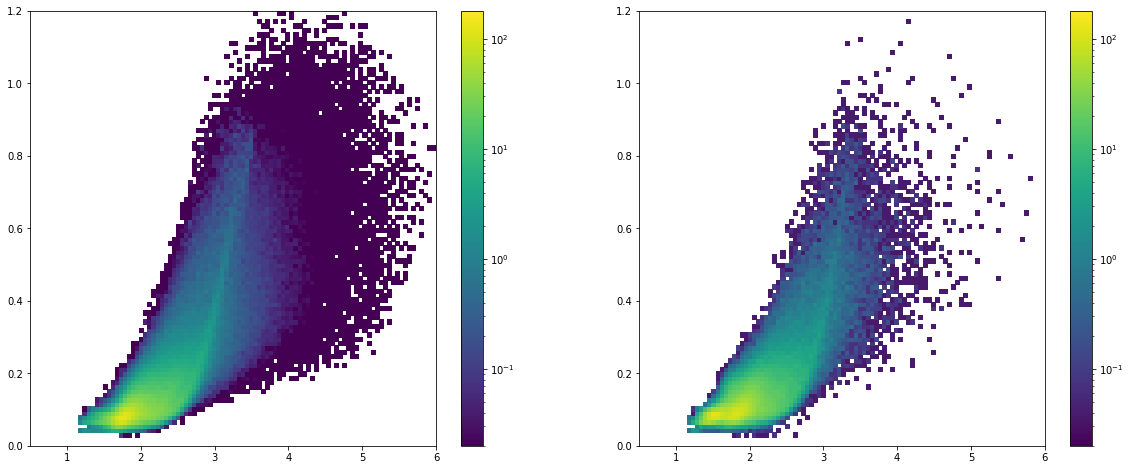

In [17]:
fig = plt.figure(figsize=(20,8))
fig.add_subplot(1, 2, 1)
zmin = 0.02
zmax = 180.
param = 'length'
h1 = plt.hist2d(np.log10(table1[mask1&radius_mask1]['intensity']), table1[mask1&radius_mask1][param], 
                weights=w1[mask1&radius_mask1],
                bins=100, range=((0.5,6.),(0.,1.2)), norm=colors.LogNorm(),
                vmin=zmin, vmax=zmax)
plt.colorbar(h1[3])
fig.add_subplot(1, 2, 2)
h2 = plt.hist2d(np.log10(light_scale_factor*table2[mask2&radius_mask2]['intensity']), table2[mask2&radius_mask2][param], 
                weights=w2[mask2&radius_mask2],
                bins=100, range=((0.5,6.),(0.,1.2)), norm=colors.LogNorm(),
                vmin=zmin, vmax=zmax)
plt.colorbar(h2[3])
plt.show()

2500


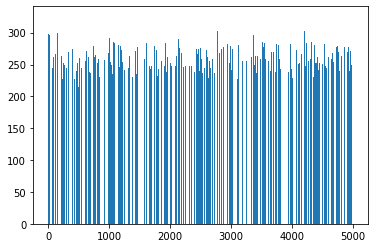

In [18]:
obs_id = np.unique(table1['obs_id'])
print(len(obs_id))
obs_id = table1['obs_id']
plt.hist(obs_id,bins=5000,range=(0.5,5000.5))
plt.show()